In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict

In [218]:
filename = "D1.txt"

def read_data(filename):
    data = pd.read_csv(filename, delimiter=" ", header=None)
    return data

d1_data = read_data("D1.txt")
d2_data = read_data("D2.txt")
druns_data = read_data("Druns.txt")
d3leaves_data = read_data("D3leaves.txt")
dbig_data = read_data("Dbig.txt")
data = read_data(filename)

In [275]:

def check_termination(data):
    label_col = list(data.columns)[-1]
    labels = list(data[label_col])
    if len(labels) == 0:
        return [True, None]
    else:
        if sum(labels) == 0:
            return [True, 0]
        elif sum(labels) == len(labels):
            return [True, 1]
    return [False, None]
    

def find_candidate_splits(data):
    splits = defaultdict(list)
    feature_cols = list(data.columns)[:-1]
    label_col = list(data.columns)[-1]
    
    for feature in feature_cols:
        feature_sorted = data.sort_values([feature, label_col])
        splits[feature] = np.unique(list(feature_sorted[feature]))
    return splits

def get_probabilites(data):
    label_col = list(data.columns)[-1]
    labels = list(data[label_col])
    counts = sum(labels)
    if len(labels) == 0:
        return [0, 0]
    prob_1 = counts/len(labels)
    return [1-prob_1, prob_1]

def entropy(probs):
    return sum([-prob*np.log2(prob) if prob!=0 else 0 for prob in probs])

def calculate_information(data):
    probs = get_probabilites(data)
    return entropy(probs)

In [326]:
def calculate_information_gain(data, feature, split_thresh):
    
    data_split_less = data[data[feature] < split_thresh]
    data_split_more = data[data[feature] >= split_thresh]
    
    [entropy_data, entropy_split_less, entropy_split_more] = map(
        calculate_information, [data, data_split_less, data_split_more])
    
    split_ratio = [len(data_split_less)/len(data), len(data_split_more)/len(data)]

    info_gain = entropy_data - (split_ratio[0]*entropy_split_less + 
                                split_ratio[1]*entropy_split_more)
    
    # print(feature, split_thresh, entropy_data, entropy_split_less, entropy_split_more)
    if entropy(split_ratio) == 0:
        return [info_gain, None]
    return [info_gain, info_gain/entropy(split_ratio)]


def get_information_gain_ratio(data, debug=False):
    splits = find_candidate_splits(data)
    information_gain_ratio_info = defaultdict(list)
    information_gain_info = defaultdict(list)
    for feature in splits.keys():
        candidates = splits[feature]
        # print(candidates)
        for candidate_thresh in candidates:
            
            info_gain = calculate_information_gain(data, feature, candidate_thresh)
            information_gain_info[feature].append(info_gain[0])
            # print(candidate_thresh, info_gain[0], info_gain[1])
            if info_gain[1] != None:
                information_gain_ratio_info[feature].append(info_gain[1])
            else:
                if debug:
                    print(feature, candidate_thresh, info_gain[0], info_gain[1])
                information_gain_ratio_info[feature].append(info_gain[0])
    return splits, information_gain_ratio_info, information_gain_info
    

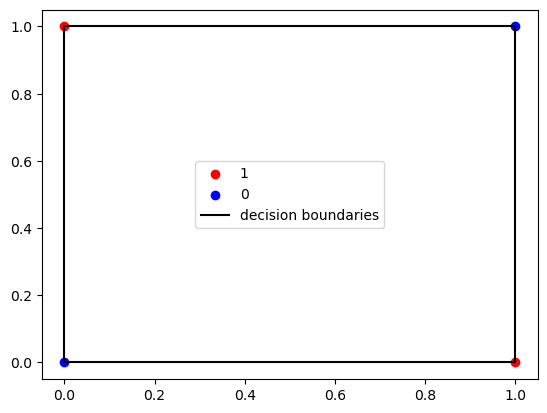

In [327]:
from matplotlib import pyplot as plt
example_data = read_data("example.txt")
plt.scatter(example_data[example_data[2] == 1][0], 
            example_data[example_data[2] == 1][1], color='red', label='1')
plt.scatter(example_data[example_data[2] == 0][0], 
            example_data[example_data[2] == 0][1], color='blue', label='0')
plt.plot([x for x in np.arange(0,1.1,0.1)], [1 for x in np.arange(0,1.1,0.1)], color='black', label='decision boundaries')
plt.plot([x for x in np.arange(0,1.1,0.1)], [0 for x in np.arange(0,1.1,0.1)], color='black')

plt.plot([1 for x in np.arange(0,1.1,0.1)],[x for x in np.arange(0,1.1,0.1)],  color='black')
plt.plot([0 for x in np.arange(0,1.1,0.1)],[x for x in np.arange(0,1.1,0.1)],  color='black')
plt.legend()

In [537]:
## Information Gain ratio exercise
features, information_gain, info_gain_ratio=get_information_gain_ratio(druns_data, debug=True)
print(information_gain, info_gain_ratio)
for k in features.keys():
    for v, info_gain, ratio in zip(features[k], information_gain[k], info_gain_ratio[k]):
        print(f' (x{k+1},{v}) &  {info_gain} &  {ratio} \\\\')
    

0 0.0 0.0 None
1 -2 0.0 None
defaultdict(<class 'list'>, {0: [0.0, 0.10051807676021828], 1: [0.0, 0.10051807676021828, 0.055953759631263526, 0.00578004220515232, 0.0011443495172767494, 0.016411136842102134, 0.049749064181778546, 0.11124029586339801, 0.23609960614360798, 0.055953759631263526, 0.4301569161309807]}) defaultdict(<class 'list'>, {0: [0.0, 0.04417739186726133], 1: [0.0, 0.04417739186726133, 0.03827452220629246, 0.004886164091842726, 0.0010821659130775263, 0.016313165825732057, 0.04945207278939401, 0.10519553207004628, 0.19958702318968735, 0.03827452220629246, 0.18905266854301617]})
 (x1,0.0) &  0.0 &  0.0 \\
 (x1,0.1) &  0.10051807676021828 &  0.04417739186726133 \\
 (x2,-2) &  0.0 &  0.0 \\
 (x2,-1) &  0.10051807676021828 &  0.04417739186726133 \\
 (x2,0) &  0.055953759631263526 &  0.03827452220629246 \\
 (x2,1) &  0.00578004220515232 &  0.004886164091842726 \\
 (x2,2) &  0.0011443495172767494 &  0.0010821659130775263 \\
 (x2,3) &  0.016411136842102134 &  0.0163131658257320

In [329]:
def get_max_info_gain_feature_thresh(data):
    info_gain_details = get_information_gain_ratio(data)
    #Compare different features
    feature_thresh, info_gain_ratio = info_gain_details[0], info_gain_details[2]
    (choose_feature, max_info_gain) = sorted([(k, max(v)) for k,v in info_gain_ratio.items()], 
                           key= lambda x: (x[1], x[0]), reverse=True)[0]

    #Choose the maximum info_gain_ratio candidate
    for index in range(len(info_gain_ratio[choose_feature])):
        if info_gain_ratio[choose_feature][index] == max_info_gain:
            choose_thresh = feature_thresh[choose_feature][index]
    return choose_feature, choose_thresh, max_info_gain

In [564]:
class TreeNode:
    def __init__(self, node_id):
        self.node_id = node_id
        self.feature = None
        self.thresh = None
        self.left = None
        self.right = None
        self.label = None
        self.predicate = None
        self.interpretation = defaultdict(list)
        
    def add_leaf(self, label):
        self.label = label

    def add_node(self, feature, thresh, left, right):
        self.feature = feature
        self.thresh = thresh
        self.left = left
        self.right = right
    
    def predict(self, data_point):
        if self.left == None and self.right == None:
            return self.label
        if data_point[self.feature] >= self.thresh:
            return self.left.predict(data_point)
        else:
            return self.right.predict(data_point)
    
    def generate_predicates(self):
        if self.predicate != None:
            return
        if self.right == None and self.left == None:
            self.predicate = f" => {self.label}"
            return
        self.predicate = f'x{self.feature+1} >= {self.thresh}'
        
        if self.right != None:
            self.right.generate_predicates()
        
        if self.left != None:
            self.left.generate_predicates()
    
    def print_node(self):
        node_info = f"node id: {self.node_id} &"
        
        if self.right == None and self.left == None:
            node_info += f" is leaf: True & label:{self.label}\\\\"
        elif self.right == None:
            node_info += f" feature: x{self.feature+1} >= {self.thresh}"
            node_info += f"& left: {self.left.node_id} right: None\\\\"
        elif self.left == None:
            node_info += f" feature: x{self.feature+1} >= {self.thresh}"
            node_info += f"& left: None right: {self.right.node_id}\\\\"
        else:
            node_info += f" feature: x{self.feature+1} >= {self.thresh}"
            node_info += f"& left: {self.left.node_id} right: {self.right.node_id}\\\\"
        
        print(node_info)
        if self.left != None:
            self.left.print_node()
        if self.right != None:
            self.right.print_node()
        

In [565]:
def decision_tree_builder(data, node_id="0"):

    ## checks for empty node and all labels being equal
    termination = check_termination(data)
    if termination[0] == True:
        node = TreeNode(node_id)
        node.add_leaf(termination[1])
        return node
    
    feature, thresh, max_info_gain = get_max_info_gain_feature_thresh(data)
    
    ## If no majority class then y will predict 1
    if max_info_gain==0:
        label_col = list(data.columns)[-1]
        labels = list(data[label_col])
        label = 0
        if sum(labels) >= len(labels)/2:
            label = 1
        node = TreeNode(node_id)
        node.add_leaf(label)
        return node

    data_split_less = data[data[feature] < thresh]
    data_split_more = data[data[feature] >= thresh]
    
    right = decision_tree_builder(data_split_less, node_id+"0")
    left = decision_tree_builder(data_split_more, node_id+"1")
    
    if left.feature == None and left.label == None:
        left = None
        
    if right.feature == None and right.label == None:
        right = None

    node = TreeNode(node_id)
    node.add_node(feature, thresh, left, right)
    return node


In [566]:
def get_all_leaves(n, leaves=[]):
    if n.left == None and n.right == None:
        leaves.append(n.node_id)
        return leaves
    if n.left != None:
        leaves = get_all_leaves(n.left, leaves)
    if n.right != None:
        leaves = get_all_leaves(n.right, leaves)
    return leaves
    

In [567]:
def get_nodes_info(n, depth=0, total_nodes=0):
    if n.left == None and n.right == None:
        return depth, total_nodes+1
    if n.left != None:
        depth_left, total_nodes = get_nodes_info(n.left, depth+1, total_nodes+1)
    if n.right != None:
        depth_right, total_nodes = get_nodes_info(n.right, depth+1, total_nodes+1)
    return max(depth_left, depth_right), total_nodes      

In [568]:
def get_all_predicates(n, predicates = defaultdict(list)):
    if n.left == None and n.right == None:
        predicates[n.node_id].append(n.predicate)
        return predicates
    if not(n.left == None and n.right == None):
        predicates[n.node_id].append(n.predicate)
    if n.left != None:
        predicates = get_all_predicates(n.left, predicates)
    if n.right != None:
        predicates = get_all_predicates(n.right, predicates)
    return predicates               

In [583]:
def get_interpretation(n):
    n.generate_predicates()
    leaves = get_all_leaves(n, [])
    predicate_list = get_all_predicates(n, defaultdict(list))
    interpretations = []
    for leaf in leaves:
        interpretation = ""
        for index in range(0, len(leaf)-1):
            if leaf[index+1] == "1":
                interpretation += "AND " + predicate_list[leaf[:index+1]][0] + " "
            if leaf[index+1] == "0":
                interpretation += "AND (NOT " + predicate_list[leaf[:index+1]][0] + ") "
        interpretation += predicate_list[leaf][0]
        interpretations.append(interpretation[4:])
    return interpretations       
        
        

In [584]:
def plot_decision_boundary(data, predicates, xrange=[-2,2], title="Plot fig"):
    all_predicates = np.array([v for k,v in predicates.items()]).flatten()
    plot_predicates = {'x1':[], 'x2':[]}
    for predicate in all_predicates:
        if '=>' in predicate:
            continue
        if 'x1' in predicate:
            plot_predicates['x1'].append(predicate)
        if 'x2' in predicate:
            plot_predicates['x2'].append(predicate)
    # print(plot_predicates)
    for predicate in plot_predicates['x2']:
        thresh = float(predicate.split(">=")[-1])
        plt.plot([x for x in range(xrange[0],xrange[1])], 
                 [thresh for x in range(xrange[0],xrange[1])], color='g')

    for predicate in plot_predicates['x1']:
        thresh = float(predicate.split(">=")[-1])
        plt.plot([thresh for x in range(xrange[0],xrange[1])],
                 [x for x in range(xrange[0],xrange[1])], color='g')
        
    plt.scatter(data[data[2]==1][0], data[data[2]==1][1], color='red', label='1')
    plt.scatter(data[data[2]==0][0], data[data[2]==0][1], color='blue', label='0')
    plt.legend()
    plt.savefig(f"{title}.pdf")
    plt.close()

In [585]:

n = decision_tree_builder(druns_data)
n.print_node()
get_interpretation(n)

node id: 0 & feature: x2 >= 6& left: 01 right: 00\\
node id: 01 & feature: x2 >= 8& left: 011 right: 010\\
node id: 011 & is leaf: True & label:1\\
node id: 010 & feature: x2 >= 7& left: 0101 right: 0100\\
node id: 0101 & is leaf: True & label:0\\
node id: 0100 & is leaf: True & label:1\\
node id: 00 & feature: x2 >= 0& left: 001 right: 000\\
node id: 001 & is leaf: True & label:0\\
node id: 000 & feature: x2 >= -1& left: 0001 right: 0000\\
node id: 0001 & is leaf: True & label:1\\
node id: 0000 & is leaf: True & label:0\\


['x2 >= 6 AND x2 >= 8  => 1',
 'x2 >= 6 AND (NOT x2 >= 8) AND x2 >= 7  => 0',
 'x2 >= 6 AND (NOT x2 >= 8) AND (NOT x2 >= 7)  => 1',
 '(NOT x2 >= 6) AND x2 >= 0  => 0',
 '(NOT x2 >= 6) AND (NOT x2 >= 0) AND x2 >= -1  => 1',
 '(NOT x2 >= 6) AND (NOT x2 >= 0) AND (NOT x2 >= -1)  => 0']

In [586]:
dleaves = read_data("D3leaves.txt")
n = decision_tree_builder(dleaves)
n.print_node()
get_interpretation(n)

node id: 0 & feature: x2 >= 2& left: 01 right: 00\\
node id: 01 & is leaf: True & label:1\\
node id: 00 & feature: x1 >= 10& left: 001 right: 000\\
node id: 001 & is leaf: True & label:1\\
node id: 000 & is leaf: True & label:0\\


['x2 >= 2  => 1',
 '(NOT x2 >= 2) AND x1 >= 10  => 1',
 '(NOT x2 >= 2) AND (NOT x1 >= 10)  => 0']

In [587]:
n_d1 = decision_tree_builder(d1_data)
n_d1.print_node()
get_interpretation(n_d1)
plot_decision_boundary(d1_data, get_all_predicates(n_d1, defaultdict(list)), xrange=[0,2], title="d1_data")

node id: 0 & feature: x2 >= 0.201829& left: 01 right: 00\\
node id: 01 & is leaf: True & label:1\\
node id: 00 & is leaf: True & label:0\\


In [591]:
n_d2 = decision_tree_builder(d2_data)
n_d2.print_node()
get_interpretation(n_d2)
plot_decision_boundary(d2_data, get_all_predicates(n_d2, defaultdict(list)), xrange=[0,2], title="d2_data")

node id: 0 & feature: x1 >= 0.533076& left: 01 right: 00\\
node id: 01 & feature: x2 >= 0.383738& left: 011 right: 010\\
node id: 011 & feature: x1 >= 0.550364& left: 0111 right: 0110\\
node id: 0111 & is leaf: True & label:1\\
node id: 0110 & feature: x2 >= 0.474971& left: 01101 right: 01100\\
node id: 01101 & is leaf: True & label:1\\
node id: 01100 & is leaf: True & label:0\\
node id: 010 & feature: x1 >= 0.761423& left: 0101 right: 0100\\
node id: 0101 & feature: x2 >= 0.191206& left: 01011 right: 01010\\
node id: 01011 & is leaf: True & label:1\\
node id: 01010 & feature: x1 >= 0.90482& left: 010101 right: 010100\\
node id: 010101 & feature: x2 >= 0.037708& left: 0101011 right: 0101010\\
node id: 0101011 & feature: x2 >= 0.061886& left: 01010111 right: 01010110\\
node id: 01010111 & is leaf: True & label:1\\
node id: 01010110 & feature: x2 >= 0.053702& left: 010101101 right: 010101100\\
node id: 010101101 & is leaf: True & label:0\\
node id: 010101100 & is leaf: True & label:1\\
n

In [592]:
get_interpretation(n_d2)

['x1 >= 0.533076 AND x2 >= 0.383738 AND x1 >= 0.550364  => 1',
 'x1 >= 0.533076 AND x2 >= 0.383738 AND (NOT x1 >= 0.550364) AND x2 >= 0.474971  => 1',
 'x1 >= 0.533076 AND x2 >= 0.383738 AND (NOT x1 >= 0.550364) AND (NOT x2 >= 0.474971)  => 0',
 'x1 >= 0.533076 AND (NOT x2 >= 0.383738) AND x1 >= 0.761423 AND x2 >= 0.191206  => 1',
 'x1 >= 0.533076 AND (NOT x2 >= 0.383738) AND x1 >= 0.761423 AND (NOT x2 >= 0.191206) AND x1 >= 0.90482 AND x2 >= 0.037708 AND x2 >= 0.061886  => 1',
 'x1 >= 0.533076 AND (NOT x2 >= 0.383738) AND x1 >= 0.761423 AND (NOT x2 >= 0.191206) AND x1 >= 0.90482 AND x2 >= 0.037708 AND (NOT x2 >= 0.061886) AND x2 >= 0.053702  => 0',
 'x1 >= 0.533076 AND (NOT x2 >= 0.383738) AND x1 >= 0.761423 AND (NOT x2 >= 0.191206) AND x1 >= 0.90482 AND x2 >= 0.037708 AND (NOT x2 >= 0.061886) AND (NOT x2 >= 0.053702)  => 1',
 'x1 >= 0.533076 AND (NOT x2 >= 0.383738) AND x1 >= 0.761423 AND (NOT x2 >= 0.191206) AND x1 >= 0.90482 AND (NOT x2 >= 0.037708)  => 0',
 'x1 >= 0.533076 AND (NO

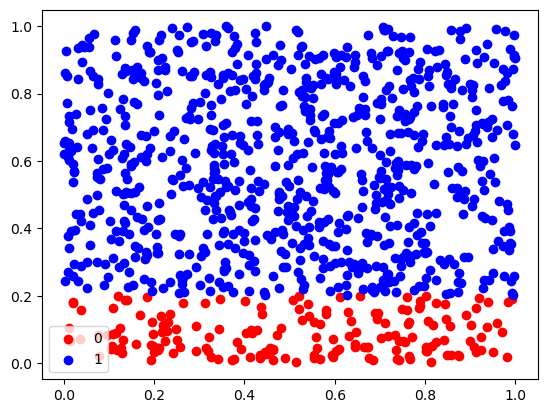

In [431]:
plt.scatter(d1_data[d1_data[2]==0][0], d1_data[d1_data[2]==0][1], color='red', label='0')
plt.scatter(d1_data[d1_data[2]==1][0], d1_data[d1_data[2]==1][1], color='blue', label='1')
plt.legend()

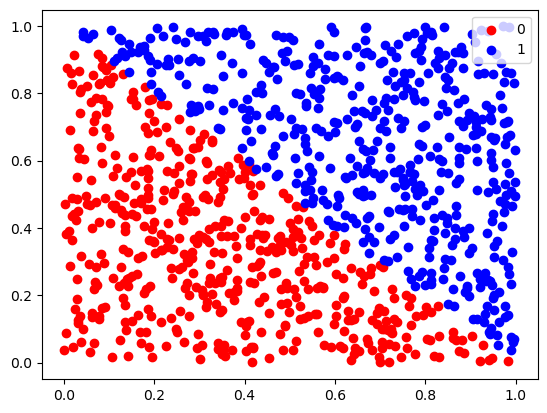

In [432]:
plt.scatter(d2_data[d2_data[2]==0][0], d2_data[d2_data[2]==0][1], color='red', label='0')
plt.scatter(d2_data[d2_data[2]==1][0], d2_data[d2_data[2]==1][1], color='blue', label='1')
plt.legend()

In [596]:
from sklearn.utils import shuffle
dbig_data_shuffled = shuffle(dbig_data)

errors = []
for train_size in [32,128,512,2048,8192]:
    data = dbig_data_shuffled.iloc[:train_size, :]
    test = dbig_data_shuffled.iloc[train_size:,:]
    DT_clf = decision_tree_builder(data)
    DT_clf.generate_predicates()
    plot_decision_boundary(data, get_all_predicates(DT_clf, defaultdict(list)),
                           xrange=[-2,3], title=f"Dbig_{train_size}")
    
    node_info = get_nodes_info(DT_clf)
    leaves = get_all_leaves(DT_clf, [])
    predicted_labels = []
    for data_point in zip(test[0], test[1]):
        predicted_labels.append(DT_clf.predict(data_point))
    correct_labels = test[2]
    
    count = 0
    for predict, correct in zip(predicted_labels, correct_labels):
        if predict != correct:
            count +=1
    error = count/(len(predicted_labels))
    # print(f'n(Train set size): {train_size}, Number of leaves: {len(leaves)}, \
    #     Number of Nodes: {node_info},  err_n (Error for D_n): {error}')
    print(f'{train_size} \& {node_info[0]} \& {node_info[1]} \& {error}\\\\')
    errors.append(error)
    
plt.plot([32,128,512,2048,8192], errors)
plt.xlabel('training set size')
plt.ylabel('mis-classification error')
plt.title(r"n vs $err_n$")
plt.savefig("n_vs_err_n.pdf")
plt.close()

32 \& 5 \& 16 \& 0.2081661316211878\\
128 \& 7 \& 28 \& 0.08731766612641816\\
512 \& 9 \& 64 \& 0.059232715008431705\\
2048 \& 12 \& 124 \& 0.023893360160965795\\
8192 \& 16 \& 346 \& 0.012168141592920354\\


In [597]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

errors = []
for train_size in [32,128,512,2048,8192]:
    data = dbig_data_shuffled.iloc[:train_size, :]
    test = dbig_data_shuffled.iloc[train_size:,:]
    DT_clf = DecisionTreeClassifier()
    DT_clf.fit(data[[0,1]], data[2])
    depth = DT_clf.get_depth()
    leaves = DT_clf.get_n_leaves()
    params = DT_clf.get_params()
    
    score = DT_clf.score(test[[0,1]], test[2])
    # print(depth, leaves, 1-score)
    print(f'{train_size} \&  {depth} \& {leaves} \& {1-score}\\\\')
    errors.append(1-score)

plt.plot([32,128,512,2048,8192], errors)
plt.xlabel('training set size')
plt.ylabel('mis-classification error')
plt.title(r"n vs $err_n$")
plt.savefig("n_vs_err_n_scipy.pdf")
plt.close()

32 \&  5 \& 6 \& 0.1688402889245586\\
128 \&  7 \& 11 \& 0.08822933549432743\\
512 \&  9 \& 24 \& 0.049430860033726765\\
2048 \&  13 \& 62 \& 0.03005533199195176\\
8192 \&  13 \& 121 \& 0.011061946902654829\\


In [539]:
#For Lagrange interpolation problem; considering a = 0, b=1

X = np.random.uniform(0,1, 100)
Y = [np.sin(x) for x in X]

In [540]:
X_test = np.random.uniform(0,1, 100)
Y_test = [np.sin(x) for x in X_test]

In [541]:
def lagrange_poly(x,X,Y):
    vals = []
    for index in range(len(X)):
        vals.append(Y[index]*np.prod([(x-X[ind])/(X[index]-X[ind]) 
                        if ind != index else 1 for ind in range(len(X))]))
    return np.sum(vals)
        

In [545]:
y_predict_train = [lagrange_poly(x,X,Y) for x in X]
error_on_train = np.mean(np.abs(np.array(y_predict_train) - np.array(Y))**2)
error_on_train
## As the model overfits because of the definition of Lagrangian Polyinomial, the error on the training set will be zero

0.0

In [543]:
y_predict_test = [lagrange_poly(x,X,Y) for x in X_test]
error_on_test = np.log(np.mean(np.abs(np.array(y_predict_test) - np.array(Y_test))**2))
error_on_test
## This is a log error; probable cause of overfitting on train data, it is unable to perform good on test data

44.67538491244841

In [546]:
## code for the addition of Gaussian Noise to the training samples and rechecking
deviations = np.linspace(0,1,100)
test_errors = []
train_errors = []
train_rev_errors = []
for deviation in deviations:
    X_train = np.random.uniform(0,1, 100) + np.random.normal(0, deviation, 100)
    Y_train = [np.sin(x) for x in X_test]
    
    y_predict_train = [lagrange_poly(x,X,Y) for x in X_train]
    error = np.log(np.mean(np.abs(np.array(y_predict_train) - np.array(Y_train))**2))
    train_errors.append(error)
    
    y_predict_train = [lagrange_poly(x,X_train,Y_train) for x in X]
    error = np.log(np.mean(np.abs(np.array(y_predict_train) - np.array(Y))**2))
    train_rev_errors.append(error)
    
    y_predict = [lagrange_poly(x,X_train,Y_train) for x in X_test]
    error = np.log(np.mean(np.abs(np.array(y_predict) - np.array(Y_test))**2))
    test_errors.append(error)


In [547]:
plt.plot(deviations, train_errors)
plt.xlabel(r"standard deviation for Gaussian Noise")
plt.ylabel("log(MSE error)")
plt.title("Training with uniform and training error on Gaussian noise added samples")
plt.savefig("train_uniform_error_GaussianNoise.pdf")
plt.close()

plt.plot(deviations, train_rev_errors)
plt.xlabel(r"standard deviation for Gaussian Noise")
plt.ylabel("log(MSE error)")
plt.title("Training with Gaussian noise added samples and error on uniform samples")
plt.savefig("train_GaussianNoise_error_uniform.pdf")
plt.close()

plt.plot(deviations, test_errors)
plt.xlabel(r"standard deviation for Gaussian Noise")
plt.ylabel("log(MSE error)")
plt.savefig("lagrange_GaussianNoise.pdf")
plt.close()